# Pilot study: relationship between peak tangential pedal force angle and power/cadence

- gemiddelde polar plot laten zien
- gemiddelde plot vergelijken met gemiddelde per training
- gemiddelde plot voor verschillende vermogensranges
- relatie tussen vermogen, cadence en peak power

## Introduction

The pedalling motion is characterized by a circular movement where the goal is is to deliver as much work as possible  tangentially (i.e. perpendicular to the crank arms). It is already known that the force with which this work is delivered is not constant throughout the pedalling motion but includes dead spots where the crank arms are vertical, likely because it is difficult for cyclists to apply the horizontal tangential force at those locations. This article will not focus on the dead spots but on the peak tangential force angles during the downward motion of the pedals/cranks to gain an understanding on the relationship of power and cadence on these angles.

## Methods

On a Wattbike indoor bike a resultant of the tangential pedal force is measured by measuring the tension on the chain. The tension is measured with a constant frequency of 100Hz which results in different number of datapoints for each pedal revolution depending on the cadence. The excellent library [wblib](https://github.com/aartgoossens/wblib) interpolates and normalizes these datapoints to 360 datapoints per revolution (1 datapoint per degree) so analyzing the data is quite straightforward.

## Initialization and retrieving data

In [10]:
from datetime import date

import pandas as pd
from sklearn import linear_model
from wblib.models import WattbikeDataFrame

%matplotlib inline

In [2]:
user_id = 'u-1756bbba7e2a350'

In [22]:
#wdf = WattbikeDataFrame()
#wdf = wdf.load_for_user(user_id, after=date(2017, 1, 1))
wdf = WattbikeDataFrame(pd.read_csv('./data.csv'))

In [4]:
print('Memory usage of all data: {}MB'.format(int(round(wdf.memory_usage().sum()/1000000))))

Memory usage of all data: 519MB


In [5]:
print('Number of sessions: {}'.format(len(set(wdf.session_id))))

Number of sessions: 33


In [7]:
print('Number of pedal revolutions: {}'.format(len(wdf)))

Number of pedal revolutions: 166659


In [17]:
wdf = wdf.assign(
    mean_peak_angle=wdf[['right_max_angle', 'left_max_angle']].mean(axis=1)
)

In [18]:
wdf = wdf[['session_id', 'power', 'cadence', 'mean_peak_angle']]

In [21]:
wdf.to_csv('./data.csv')

## Average Polar Plot

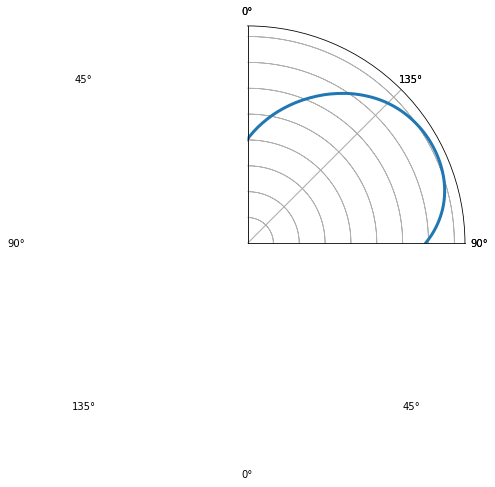

In [6]:
wdf.plot.polar()

## Average Polar Plot per session

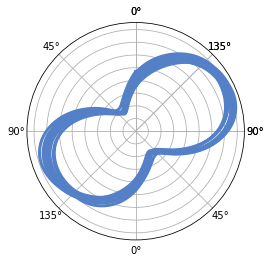

In [9]:
for session_id in set(wdf.session_id):
    a = wdf.loc[wdf.session_id == session_id].plot.polar()

## Average polar plot for power ranges

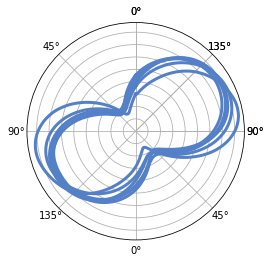

In [10]:
min_power = 0
max_power = 100
while max_power <= 600:
    wdf.loc[wdf.power.between(min_power, max_power)].plot.polar()
    min_power += 100
    max_power += 100

## Relationship between power, cadence and peak angle

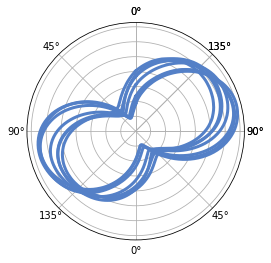

In [11]:
min_cadence = 50
max_cadence = 60
while max_cadence <= 120:
    wdf.loc[wdf.cadence.between(min_cadence, max_cadence)].plot.polar()
    min_cadence += 10
    max_cadence += 10

Relationship between power and cadence and peak force angle, calculated with multiple linear regression:

In [29]:
reg = linear_model.LinearRegression()
wdf_dropped_na = wdf[['power', 'cadence', 'anglePeakForce_leftAngle']].dropna()
reg.fit (wdf_dropped_na[['power', 'cadence']].as_matrix(), wdf_dropped_na.anglePeakForce_leftAngle.as_matrix())
reg.coef_

array([-0.0288664 ,  0.57737325])

Relationship between power and cadence, calculated with linear regression:

In [21]:
reg = linear_model.LinearRegression()
wdf_dropped_na = wdf[['power', 'cadence']].dropna()
reg.fit (wdf_dropped_na[['power']].as_matrix(), wdf_dropped_na.cadence.as_matrix())
reg.coef_

array([ 0.05106876])

In [5]:
# from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
import statsmodels.api as sm

selected_data = wdf[['power', 'cadence', 'anglePeakForce_leftAngle']].dropna()

X = selected_data[['power', 'cadence']]
X = sm.add_constant(X)
y = selected_data['anglePeakForce_leftAngle']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

/Users/aart/Dropbox/Documents/projects/publications/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     anglePeakForce_leftAngle   R-squared:                       0.134
Model:                                  OLS   Adj. R-squared:                  0.134
Method:                       Least Squares   F-statistic:                     4497.
Date:                      Sun, 26 Nov 2017   Prob (F-statistic):               0.00
Time:                              17:10:38   Log-Likelihood:            -2.5161e+05
No. Observations:                     58211   AIC:                         5.032e+05
Df Residuals:                         58208   BIC:                         5.033e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.6884      0.507    143.426      0.000      71.695      73.682
power         -0.0289      0.001    -45.350      0.000      -0.030      -0.028
cadence        0.5774      0.006     94.586      0.000       0.565       0.589
==============================================================================
Omnibus:                    17958.211   Durbin-Watson:                   0.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           280173.880
Skew:                          -1.064   Prob(JB):                         0.00
Kurtosis:                      13.535   Cond. No.                     1.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
import statsmodels.api as sm

selected_data = wdf[['power', 'cadence', 'anglePeakForce_leftAngle', 'session_id']].dropna()

X = selected_data[['power', 'cadence']]
X = sm.add_constant(X)
y = selected_data['anglePeakForce_leftAngle']
groups = selected_data['session_id']

model = sm.MixedLM(y, X, groups).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: anglePeakForce_leftAngle
No. Observations: 58211   Method:             REML                    
No. Groups:       9       Scale:              308.3974                
Min. group size:  5610    Likelihood:         -249449.3068            
Max. group size:  7278    Converged:          Yes                     
Mean group size:  6467.9                                              
-------------------------------------------------------------------------
               Coef.     Std.Err.       z       P>|z|    [0.025    0.975]
-------------------------------------------------------------------------
const          70.316       1.861     37.789    0.000    66.669    73.963
power          -0.028       0.001    -45.057    0.000    -0.029    -0.027
cadence         0.605       0.006     97.200    0.000     0.593     0.617
Group RE       28.774       0.825                                        
======================================================================

"""

This analysis makes it clear that both power and cadence have a signficant relationship with the peak force angle: For both independent variables the p value is <0.05 (even <0.001). With a large number of samples like this (n=58211) a significant relationship between variables is highly likely so in this case it is more interesting to look at effect sizes, the coefficients. For the dependent variable power this relationship is quite small: For every 1 Watt increase in power the peak force angle decreases by 0.03 degree. For cadence this relationship is larger: For every 1 rpm increase in cadence the peak force angle increases by 0.58. This data suggests that although power has a significant relationship with peak force angle, a larger amount of the variation in peak force angle is explained by changes in cadence.

The "goodness of fit" (represented by the R^2 of 0.134) is quite low, indicating that the model cannot be used to get accurate predictions for peak force angle based on power and cadence.

## Discussion

One confounding factor in the data is that it contains revolutions in both sitting and standing positions. Standing positions seem to increase the peak force angle by a lot (I will publish an article on later) which might add noise to the data.
Removing samples where power is really low or high might remove some noise which could improve model estimates.
In large datasets it is highly likely to find significant relationships between variables although their effect sizes might be really small.